In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

In [16]:
# credit_bureau_b_1, person_1 
base_path = 'data/'

# train
train_basetable = pd.read_csv(base_path + 
                              'csv_files/train/train_base.csv')

train_credit_bureau_b_1 = pd.read_csv(base_path +
                                      'csv_files/train/train_credit_bureau_b_1.csv')


# test
test_basetable = pd.read_csv(base_path + 
                              'csv_files/test/test_base.csv')
                              
test_credit_bureau_b_1 = pd.read_csv(base_path +
                                      'csv_files/test/test_credit_bureau_b_1.csv')


#### credit_bureau_b_1

- case_id: 계약
- num_group1 = 0: 대출 신청자
- num_group1 != 0: 나머지 관련 사람들

하나의 계약에 대해서 대출 신청자를 포함하는 여러 사람들에 대한 신용 정보(credit_bureau)를 통해 target을 예측하는 것이 우리의 목표이다.

하나의 계약에 대해 여러 사람들의 신용 정보를 집계하여 계약의 지불 여부를 예측하면 된다.

따라서, 결측치 관련 처리를 따로 할 필요 없이, 정보가 있는 사람들의 정보만을 취합하면 된다.

여기서 중요한 것은 어떤 방식으로 정보를 취합하느냐이다. (평균, 중앙값, 최빈값)

만약 결측치가 존재한다면, 전체 정보에 대해 처리를 해주어야할 것이다.

credit_bureau의 주요 내용으로는
1. 활성화된 계약에 대한 내용 (금액, 유형, 날짜, 할부 주기 등)
2. 종료된 계약에 대한 내용
3. 보증 유무에 따른 계약 내용

- P – 일 수 (정수) -> 평균값을 취한 후 반올림(연체 일 수 같은 정보가 있기에 해당 정보를 담고 있어야한다고 생각)
- M – 마스킹 된 문자열 -> 최빈값 (데이터 간 순서를 매길 수 없으므로)
- A – 금액 -> 평균값 (마찬가지로 튀는 어떠한 값이 있더라도 그것이 어떠한 flag가 될 수 있기 때문에 평균값을 통해 어느정도 정보를 가지고 있어야한다고 생각)
- D – 날짜 (datetime) -> 연도-월 형식으로 변환하여 데이터 압축한 후, 최빈값 (A 날짜와 B 날짜가 있을 때, 각각의 날짜가 가지고 있는 의미가 있기 때문에 의미를 살리기 위해서)
- L – 건수(정수) , 이자율(실수) -> int형이라면 평균값 반올림, float64라면 평균값 (위와 같은 맥락)
- T – 월(1 ~ 12), 연도 -> datetime 형식으로 변환가능한 지 판단, 최빈값 (위와 같은 맥락)


In [24]:
train_credit_bureau_b_1.head(3)

,case_id,amount_1115A,classificationofcontr_1114M,contractdate_551D,contractmaturitydate_151D,contractst_516M,contracttype_653M,credlmt_1052A,credlmt_228A,credlmt_3940954A,...,pmtmethod_731M,pmtnumpending_403L,purposeofcred_722M,residualamount_1093A,residualamount_127A,residualamount_3940956A,subjectrole_326M,subjectrole_43M,totalamount_503A,totalamount_881A
0,467,NaN,ea6782cc,2011-06-15,2031-06-13,7241344e,724be82a,3000000.0,10000.0,3000000.0,...,a55475b1,NaN,96a8fdfe,0.0,0.0,NaN,fa4f56f1,ab3c25cf,3000000.0,10000.0
1,467,NaN,ea6782cc,2019-01-04,2021-08-04,7241344e,724be82a,NaN,NaN,130365.0,...,a55475b1,NaN,96a8fdfe,NaN,NaN,NaN,ab3c25cf,ab3c25cf,78000.0,960000.0
2,467,78000.0,ea6782cc,2016-10-25,2019-10-25,7241344e,4257cbed,NaN,NaN,NaN,...,e914c86c,10.0,96a8fdfe,NaN,NaN,NaN,a55475b1,a55475b1,NaN,NaN


mode().iloc[0]를 했을 때의 문제점
동일한 빈도에서 무조건 작은 수를 택하기 때문에 다음과 같이 큰 값에서 빈도가 낮아지는 경향성이 생겨버린다.

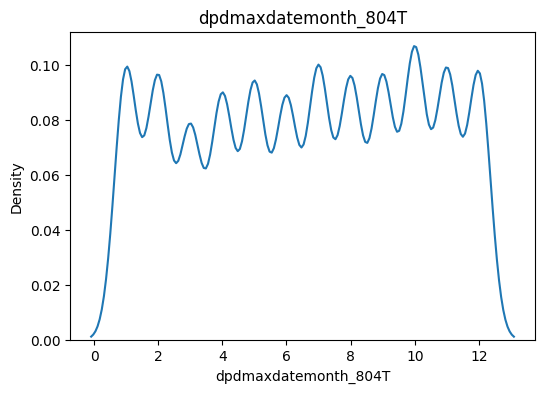
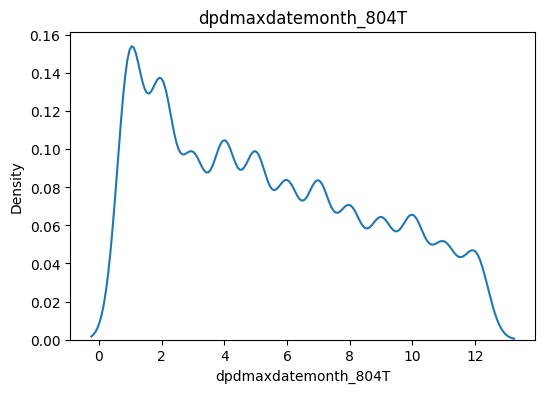

따라서 동일한 빈도에서 랜덤 선택을 하게끔 조치를 취해주었다.

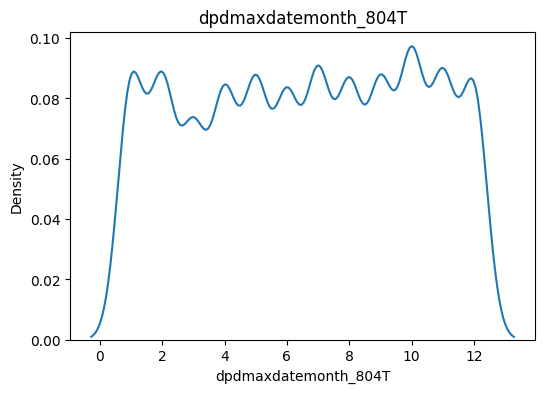

In [25]:
def aggregate_by_case_id(df:pd.DataFrame) -> pd.DataFrame:

    if 'case_id' not in df.columns:
        raise ValueError("The column 'case_id' is not exist in DataFrame.")
    
    # 집계된 데이터프레임이 들어갈 빈 데이터프레임 생성
    aggregated_df = pd.DataFrame()

    # case_id를 기준으로 그룹화
    grouped_df = df.groupby('case_id')

    for case_id, group_data in grouped_df:
        row = {'case_id': case_id}

        for col in group_data.columns:
            # 해당 column이 모두 결측치로 이루어져있을 때
            if group_data[col].isnull().all():
                row[col] = np.nan
                continue
            # 평균값의 반올림
            if col.endswith('P'):
                row[col] = round(group_data[col].mean(skipna=True)) 
            # 최빈값
            elif col.endswith('M'):
                mode_values = group_data[col].mode()
                row[col] = np.random.choice(mode_values)
            # 평균값
            elif col.endswith('A'):
                row[col] = round(group_data[col].mean(skipna=True), 3)
            # datetime 형식 변환 후 최빈값
            elif col.endswith('D'):
                mode_values = (pd.to_datetime(group_data[col], errors='coerce').dt.to_period('M')).mode()
                row[col] = np.random.choice(mode_values)
            # int: 평균값 반올림, float: 평균값
            elif col.endswith('L'):
                convert = group_data[col].dropna().astype(int)
                lossless_flag = (convert == group_data[col].dropna()).all()

                if lossless_flag:
                    row[col] = round(convert.mean(skipna=True))
                else:
                    row[col] = group_data[col].mean(skipna=True)
            # int(month: 1 ~ 12): 최빈값, object(2010-01-01): year-month 형식 변환 후 최빈값
            elif col.endswith('T'):
                if group_data[col].dtype == 'object':
                    mode_values = (pd.to_datetime(group_data[col], errors='coerce').dt.to_period('M')).mode()
                    row[col] = np.random.choice(mode_values)
                else:
                    convert = group_data[col].dropna().astype(int)
                    mode_values = convert.mode()
                    row[col] = np.random.choice(mode_values)
            
        # 결과 데이터프레임에 추가
        aggregated_df = aggregated_df.append(row, ignore_index=True)

    return aggregated_df

In [26]:
def print_info(df:pd.DataFrame, col_name, plot_flag = True):
    temp = '=' * 10 + ' [' + col_name + '] ' + '=' * 10
    print(temp) 
    print(f'데이터 타입: {df[col_name].dtype}')
    print(f'결측치의 비율: {(df[col_name].isna().sum() / df[col_name].shape[0] * 100):.1f}%')

    plt.figure(figsize=(6,4))

    if df[col_name].dtype != 'object':
        print(f'최솟값: {df[col_name].dropna().min()}')
        print(f'최댓값: {df[col_name].dropna().max()}')
        print(f'평균값: {df[col_name].dropna().mean():.3f}')
        print(f'중간값: {df[col_name].dropna().median()}')
        print('=' * len(temp))

        # 최댓값이 크면 log 변환
        if np.log10(df[col_name].dropna().max()) - np.log10(max(df[col_name].dropna().min(), 10)) > 3:
            # log 함수는 x가 0일 때 정의되지 않기 때문에 모든 값들에 1을 더해준다.
            temp = np.log10(df[col_name] + 1)

            # plot_flag가 True일 때만 그래프 출력
            if plot_flag:
                sns.kdeplot(temp, palette='Blues_r', )
                plt.xlabel('log10 converted value')
        else:
            if plot_flag:
                sns.kdeplot(df[col_name], palette='Blues_r', )

        if plot_flag:  
            plt.title(col_name)
            plt.show()
    else:
        try:
            # 날짜 데이터가 크다면 연도별 데이터로 변환하기
            if len(df[col_name].value_counts()) > 500:
                df_datetime = pd.DataFrame(pd.to_datetime(df[col_name]).dt.year).value_counts().reset_index()
            else:
                df_datetime = pd.DataFrame(pd.to_datetime(df[col_name])).value_counts().reset_index()
                
            df_datetime.columns = ['date', 'count']
            df_datetime = df_datetime.set_index('date').sort_index()
            
            print(f'최솟값: {df_datetime.idxmin().values[0]} | {df_datetime.min().values[0]}')
            print(f'최댓값: {df_datetime.idxmax().values[0]} | {df_datetime.max().values[0]}')

            print('- - ' * 5)
            print('value_counts:')
            print(df[col_name].value_counts())
            print('- - ' * 5)
            print('=' * len(temp))

            if plot_flag:
                sns.barplot(data=df_datetime['count'], palette='Blues', )
                
                if len(df_datetime['count']) > 10:
                    x_ticks_interval = int(len(df_datetime['count']) / 10)
                else:
                    x_ticks_interval = 1

                plt.xticks(range(0, len(df_datetime['count']), x_ticks_interval), rotation=90)
                plt.title(col_name)
                plt.show()

        except:
            print(f'최솟값: {df[col_name].dropna().min()}')
            print(f'최댓값: {df[col_name].dropna().max()}')

            print('- - ' * 5)
            print('value_counts:')
            print(df[col_name].value_counts())
            print('- - ' * 5)
            print('=' * len(temp))

            if plot_flag:
                if len(df[col_name].value_counts()) > 10:
                    # 상위 5개만을 추출
                    slice = 5
                else:    
                    slice = len(df[col_name])

                sns.countplot(data=df, x=col_name, order=df[col_name].value_counts()[:slice].index, palette='Blues_r', )
                plt.xticks(rotation=90, ha='right')
                plt.title(col_name)
                plt.show()

In [27]:
# 제외할 column : periodicityofpmts_997M와 같은 정보를 갖고 있는 column이면서 동시에 처리하기 힘든 데이터이기 때문에 drop 결정
train_credit_bureau_b_1['periodicityofpmts_997L']
train_credit_bureau_b_1.drop(columns='periodicityofpmts_997L', inplace=True)

In [28]:
aggregated_df = aggregate_by_case_id(train_credit_bureau_b_1)

In [29]:
# 결측치 처리: 50%가 넘는 column들은 drop
print('=' * 51)
for col in aggregated_df.columns[1:]:
    temp = aggregated_df[col]
    print(f'{col:>30} 의 결측치 비율: {temp.isna().sum() / temp.shape[0] * 100:5.2f}%')
print('=' * 51)


drop_column = []
for col in aggregated_df.columns:
    temp = aggregated_df[col]
    missing_ratio = temp.isna().sum() / temp.shape[0] * 100
    if missing_ratio > 50:
        drop_column.append(col)

aggregated_df.drop(columns=drop_column, axis=1, inplace=True)
aggregated_df

                  amount_1115A 의 결측치 비율: 30.31%
   classificationofcontr_1114M 의 결측치 비율:  0.00%
             contractdate_551D 의 결측치 비율:  0.15%
     contractmaturitydate_151D 의 결측치 비율:  0.21%
               contractst_516M 의 결측치 비율:  0.00%
             contracttype_653M 의 결측치 비율:  0.00%
                 credlmt_1052A 의 결측치 비율: 24.44%
                  credlmt_228A 의 결측치 비율: 55.82%
              credlmt_3940954A 의 결측치 비율: 24.44%
               credor_3940957M 의 결측치 비율:  0.00%
            credquantity_1099L 의 결측치 비율:  0.15%
             credquantity_984L 의 결측치 비율: 14.27%
         debtpastduevalue_732A 의 결측치 비율:  0.24%
                debtvalue_227A 의 결측치 비율: 30.31%
                      dpd_550P 의 결측치 비율:  0.15%
                      dpd_733P 의 결측치 비율: 14.27%
                   dpdmax_851P 의 결측치 비율:  0.23%
          dpdmaxdatemonth_804T 의 결측치 비율:  0.23%
           dpdmaxdateyear_742T 의 결측치 비율:  0.23%
        installmentamount_644A 의 결측치 비율: 14.27%
        installmentamount_833A 의 결측치 비율:

,case_id,amount_1115A,classificationofcontr_1114M,contractdate_551D,contractmaturitydate_151D,contractst_516M,contracttype_653M,credlmt_1052A,credlmt_3940954A,credor_3940957M,...,pmtdaysoverdue_1135P,pmtmethod_731M,pmtnumpending_403L,purposeofcred_722M,residualamount_127A,residualamount_3940956A,subjectrole_326M,subjectrole_43M,totalamount_503A,totalamount_881A
0,467,78000.000,ea6782cc,2019-01,2021-08,7241344e,724be82a,3000000.0,1565182.5,P164_34_168,...,0.0,a55475b1,10.0,96a8fdfe,0.000,NaN,fa4f56f1,ab3c25cf,1539000.00,485000.000
1,1445,132266.873,01f63ac8,2014-11,2021-01,7241344e,4257cbed,400000.0,237000.0,74bd67a8,...,0.0,a55475b1,16.0,60c73645,0.000,73044.180,a55475b1,a55475b1,398400.31,142293.900
2,1934,73971.200,ea6782cc,2012-10,2022-10,b919198c,f4e17141,980000.0,490000.0,3e8db15c,...,1889.0,a55475b1,0.0,96a8fdfe,0.000,0.000,ab3c25cf,ab3c25cf,526985.60,166942.805
3,3159,NaN,ea6782cc,2018-11,2020-11,7241344e,1c9c5356,132000.0,132000.0,b619fa46,...,0.0,a55475b1,NaN,60c73645,111858.700,111858.700,ab3c25cf,ab3c25cf,132000.00,0.000
4,3208,300000.000,a55475b1,2016-08,2019-08,a55475b1,4257cbed,NaN,NaN,6ee1295b,...,0.0,dbcbe8f8,8.0,a55475b1,NaN,NaN,a55475b1,ab3c25cf,300000.00,68500.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36495,2701996,NaN,ea6782cc,2018-05,2022-05,7241344e,1c9c5356,0.0,0.0,b619fa46,...,0.0,a55475b1,NaN,60c73645,0.000,0.000,ab3c25cf,ab3c25cf,0.00,388703.400
36496,2702661,21420.000,ea6782cc,2020-05,2020-11,7241344e,4257cbed,NaN,NaN,P0_31_66,...,0.0,f6e26148,2.0,60c73645,NaN,NaN,ab3c25cf,ab3c25cf,21420.00,281932.800
36497,2703357,731886.060,07b11743,2018-04,2020-11,7241344e,1c9c5356,72000.0,72000.0,904adb51,...,0.0,a55475b1,31.0,96a8fdfe,72000.000,72000.000,ab3c25cf,ab3c25cf,401943.03,279862.610
36498,2703377,NaN,ea6782cc,2014-01,2022-01,7241344e,1c9c5356,0.0,0.0,b619fa46,...,0.0,a55475b1,NaN,60c73645,0.000,0.000,ab3c25cf,ab3c25cf,0.00,205540.000


========== [amount_1115A] ==========
데이터 타입: float64
결측치의 비율: 30.3%
최솟값: 820.0
최댓값: 46000000.0
평균값: 216093.739
중간값: 73687.0


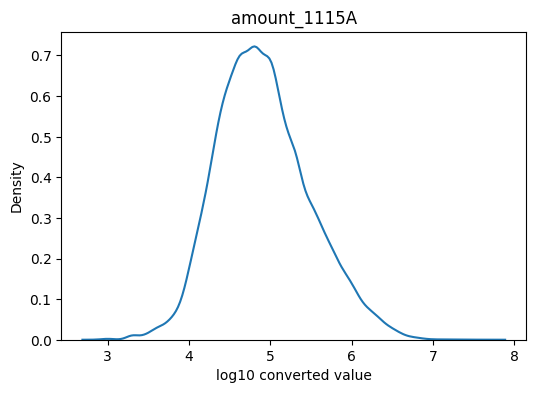

========== [classificationofcontr_1114M] ==========
데이터 타입: object
결측치의 비율: 0.0%
최솟값: 00135d9c
최댓값: ea6782cc
- - - - - - - - - - 
value_counts:
ea6782cc    30740
a55475b1     2064
01f63ac8     1901
00135d9c     1398
07b11743      237
9b63302f       96
1cf4e481       50
8b9a3257        7
90c587b1        7
Name: classificationofcontr_1114M, dtype: int64
- - - - - - - - - - 


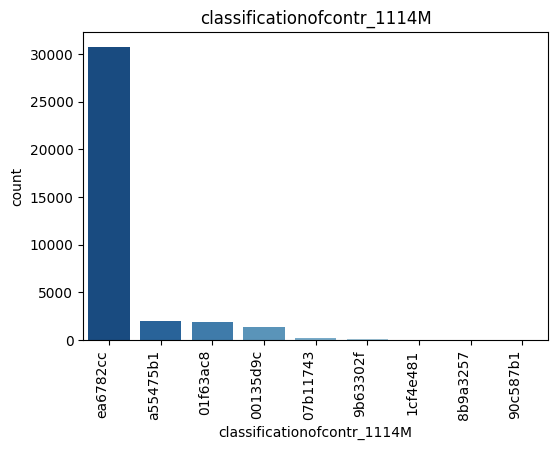

========== [contractdate_551D] ==========
데이터 타입: object
결측치의 비율: 0.1%
최솟값: 2000-09
최댓값: 2020-10
- - - - - - - - - - 
value_counts:
2019-10    1276
2019-09    1275
2019-07    1273
2019-06    1228
2019-08    1225
           ... 
2004-12       1
2005-06       1
2008-09       1
2003-10       1
2005-08       1
Freq: M, Name: contractdate_551D, Length: 187, dtype: int64
- - - - - - - - - - 


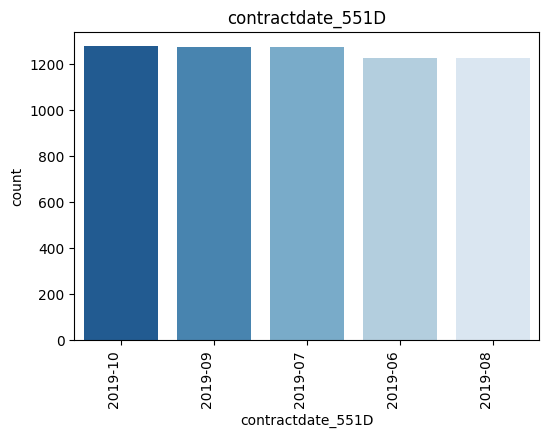

========== [contractmaturitydate_151D] ==========
데이터 타입: object
결측치의 비율: 0.2%
최솟값: 2003-04
최댓값: 2045-05
- - - - - - - - - - 
value_counts:
2020-12    1365
2021-01    1361
2020-09    1298
2021-03    1287
2020-10    1264
           ... 
2012-01       1
2043-09       1
2045-05       1
2009-11       1
2029-08       1
Freq: M, Name: contractmaturitydate_151D, Length: 374, dtype: int64
- - - - - - - - - - 


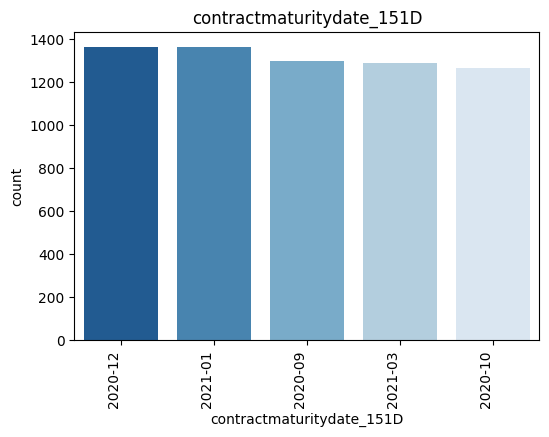

========== [contractst_516M] ==========
데이터 타입: object
결측치의 비율: 0.0%
최솟값: 04bf6e27
최댓값: fd624e63
- - - - - - - - - - 
value_counts:
7241344e    31877
a55475b1     1998
b919198c      635
8f3a197f      473
0dc85f9d      380
a52d5641      374
dd67cff0      335
04bf6e27      169
885ce291      122
83931972       51
fd624e63       46
7640edc3       34
0d5020fc        3
54132f86        3
Name: contractst_516M, dtype: int64
- - - - - - - - - - 


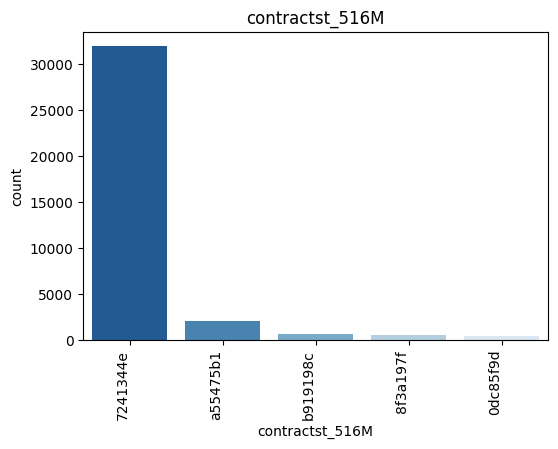

========== [contracttype_653M] ==========
데이터 타입: object
결측치의 비율: 0.0%
최솟값: 07162370
최댓값: f4e17141
- - - - - - - - - - 
value_counts:
1c9c5356    17077
4257cbed    16789
a55475b1     1961
5015212e      155
f4e17141      123
724be82a      108
6f84dcc8       93
60e784d6       52
c6678a8f       41
07162370       35
37b13a3f       24
249fb461       13
44dce3ad       11
1bc8994b        9
190917cc        3
e730315b        2
ef77dd46        1
735d178d        1
13a8fc53        1
a46b6619        1
Name: contracttype_653M, dtype: int64
- - - - - - - - - - 


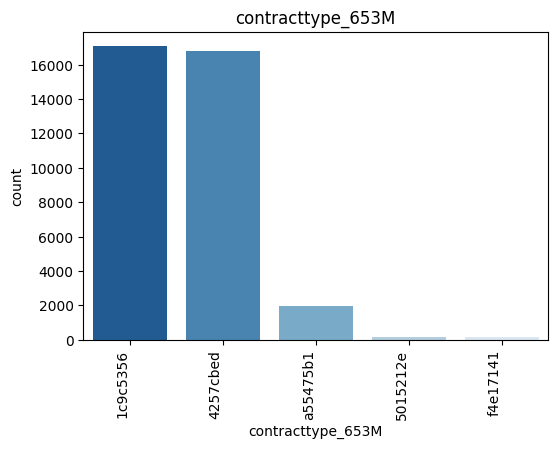

========== [credlmt_1052A] ==========
데이터 타입: float64
결측치의 비율: 24.4%
최솟값: 0.0
최댓값: 796800000.0
평균값: 178935.650
중간값: 36184.0


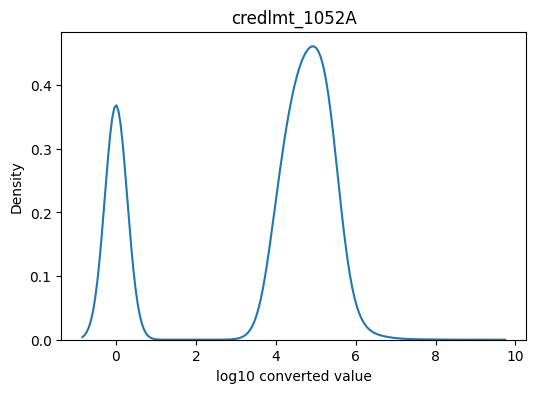

========== [credlmt_3940954A] ==========
데이터 타입: float64
결측치의 비율: 24.4%
최솟값: 0.0
최댓값: 86743333.333
평균값: 94340.546
중간값: 26598.0


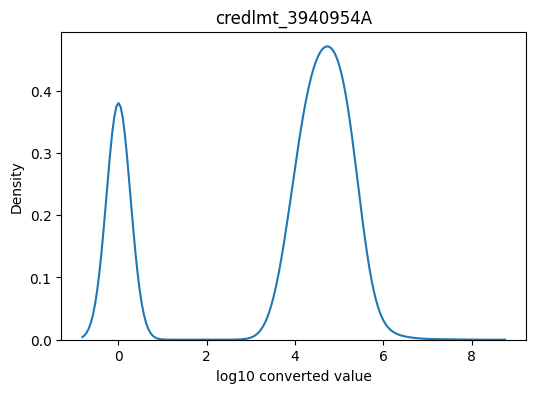

========== [credor_3940957M] ==========
데이터 타입: object
결측치의 비율: 0.0%
최솟값: 00a59564
최댓값: ff11387f
- - - - - - - - - - 
value_counts:
b619fa46     15502
P0_31_66      8236
c5a72b57      2144
P33_61_72     2072
a55475b1      2024
             ...  
23f6d743         1
1fe81d20         1
3fa63dd4         1
d1c4d78f         1
abb6ee13         1
Name: credor_3940957M, Length: 113, dtype: int64
- - - - - - - - - - 


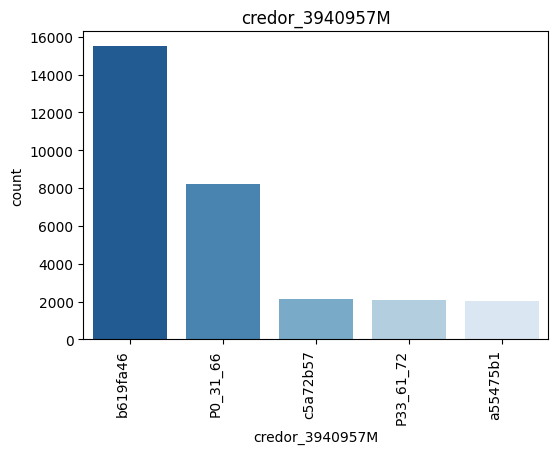

========== [credquantity_1099L] ==========
데이터 타입: float64
결측치의 비율: 0.1%
최솟값: 1.0
최댓값: 10.0
평균값: 1.597
중간값: 1.0


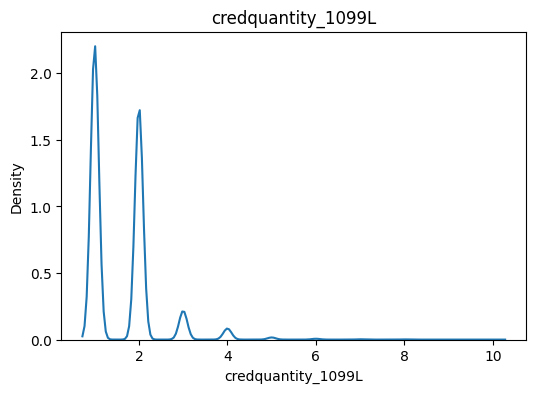

========== [credquantity_984L] ==========
데이터 타입: float64
결측치의 비율: 14.3%
최솟값: 1.0
최댓값: 146.0
평균값: 4.571
중간값: 4.0


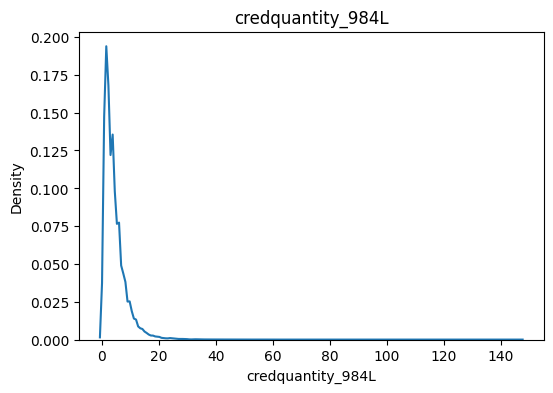

========== [debtpastduevalue_732A] ==========
데이터 타입: float64
결측치의 비율: 0.2%
최솟값: 0.0
최댓값: 15402052.646
평균값: 4277.817
중간값: 0.0


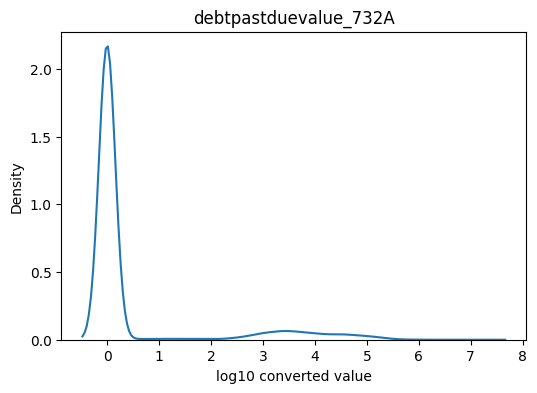

========== [debtvalue_227A] ==========
데이터 타입: float64
결측치의 비율: 30.3%
최솟값: 0.0
최댓값: 41619050.0
평균값: 167268.062
중간값: 45729.027


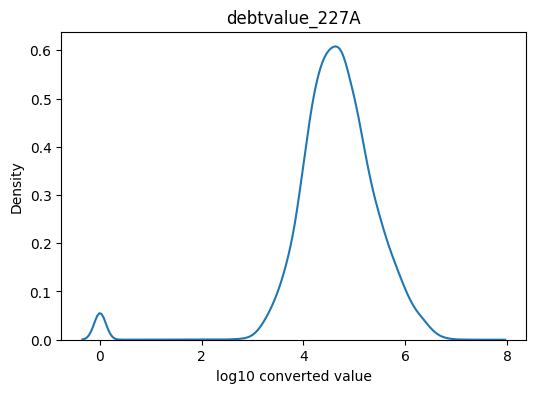

========== [dpd_550P] ==========
데이터 타입: float64
결측치의 비율: 0.1%
최솟값: 0.0
최댓값: 103911888.0
평균값: 26673.112
중간값: 0.0


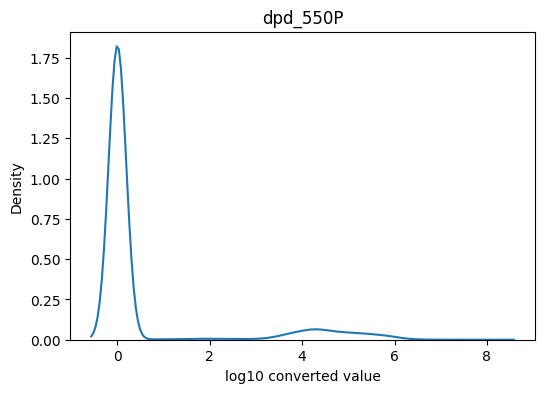

========== [dpd_733P] ==========
데이터 타입: float64
결측치의 비율: 14.3%
최솟값: 0.0
최댓값: 7721971.0
평균값: 284.971
중간값: 0.0


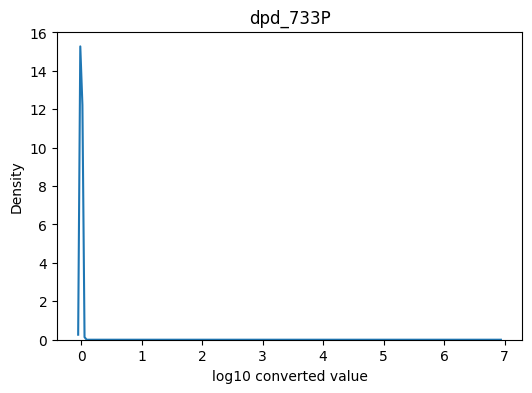

========== [dpdmax_851P] ==========
데이터 타입: float64
결측치의 비율: 0.2%
최솟값: 0.0
최댓값: 69309244.0
평균값: 39506.924
중간값: 0.0


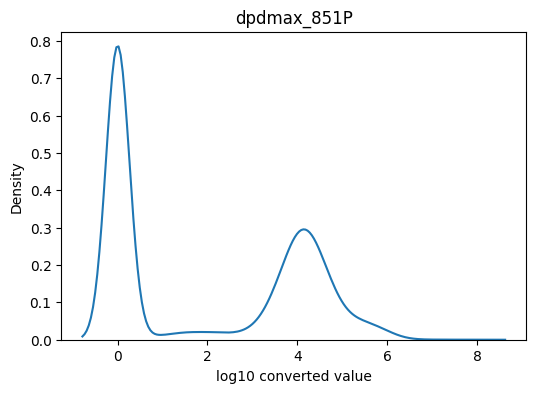

========== [dpdmaxdatemonth_804T] ==========
데이터 타입: float64
결측치의 비율: 0.2%
최솟값: 1.0
최댓값: 12.0
평균값: 6.585
중간값: 7.0


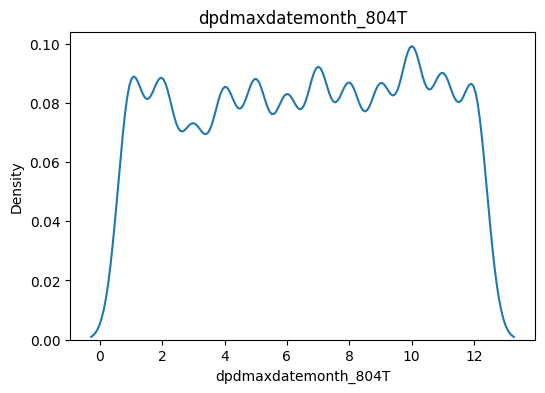

========== [dpdmaxdateyear_742T] ==========
데이터 타입: float64
결측치의 비율: 0.2%
최솟값: 2008.0
최댓값: 2020.0
평균값: 2018.155
중간값: 2019.0


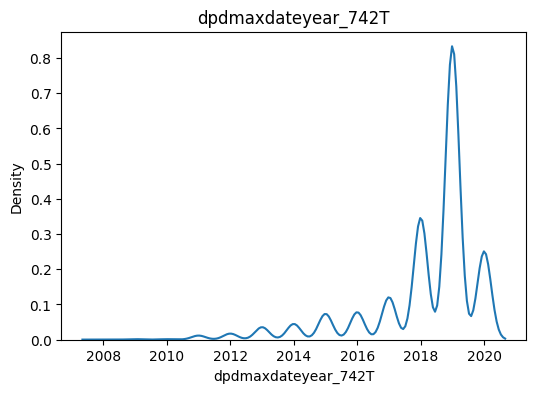

========== [installmentamount_644A] ==========
데이터 타입: float64
결측치의 비율: 14.3%
최솟값: 0.0
최댓값: 5709301.5
평균값: 318.545
중간값: 0.0


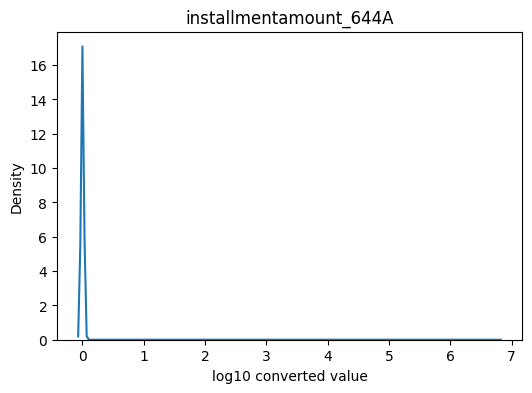

========== [installmentamount_833A] ==========
데이터 타입: float64
결측치의 비율: 0.1%
최솟값: 0.0
최댓값: 54055732.0
평균값: 145977.202
중간값: 47417.746


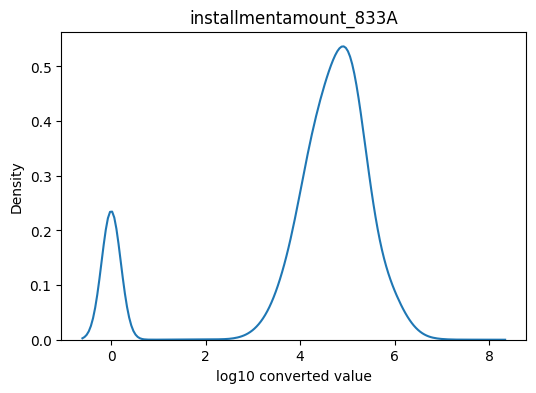

========== [instlamount_892A] ==========
데이터 타입: float64
결측치의 비율: 30.4%
최솟값: 0.0
최댓값: 13712903.333
평균값: 8822.350
중간값: 4589.2


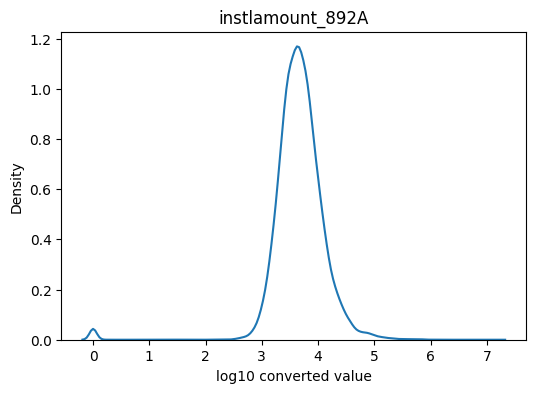

========== [interestrateyearly_538L] ==========
데이터 타입: float64
결측치의 비율: 44.9%
최솟값: 0.0
최댓값: 24770.600000000002
평균값: 45.638
중간값: 38.0


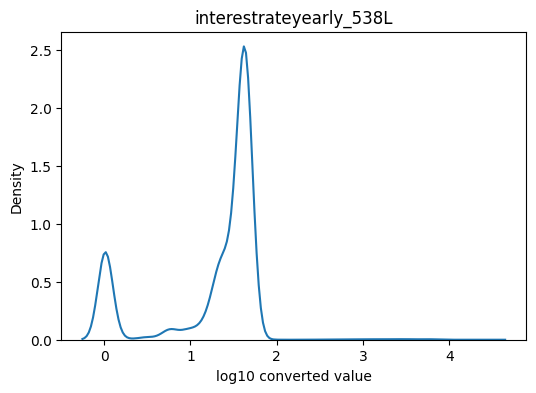

========== [lastupdate_260D] ==========
데이터 타입: object
결측치의 비율: 0.1%
최솟값: 2015-03
최댓값: 2020-10
- - - - - - - - - - 
value_counts:
2019-07    3641
2019-12    3433
2020-01    3413
2019-10    3075
2019-11    2833
2019-06    2665
2020-09    2507
2020-03    2290
2019-05    2112
2020-06    1929
2020-02    1638
2020-08    1289
2020-07    1025
2019-08     948
2019-04     853
2020-10     817
2020-05     788
2020-04     541
2019-01     238
2019-03     162
2019-02      98
2019-09      95
2018-12      53
2018-09       2
2015-04       1
2015-03       1
Freq: M, Name: lastupdate_260D, dtype: int64
- - - - - - - - - - 


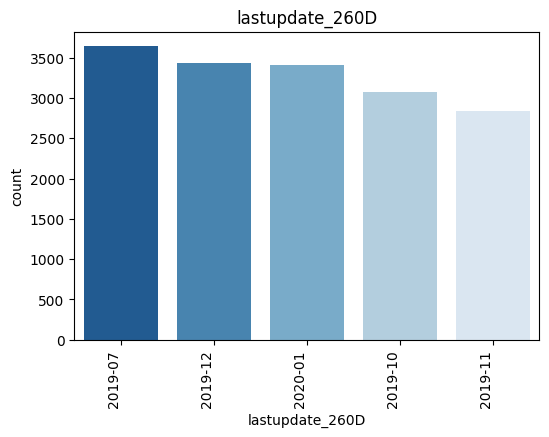

========== [maxdebtpduevalodued_3940955A] ==========
데이터 타입: float64
결측치의 비율: 0.2%
최솟값: 0.0
최댓값: 37122.252
평균값: 13.114
중간값: 0.0


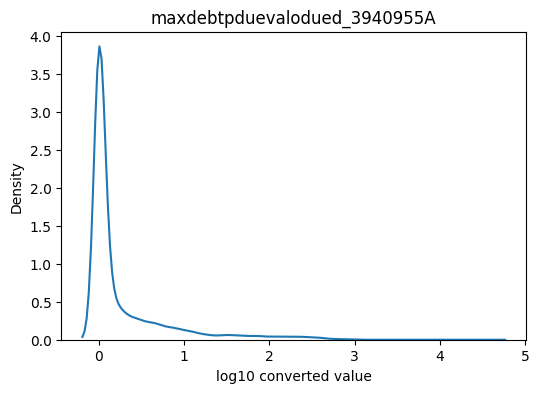

========== [numberofinstls_810L] ==========
데이터 타입: float64
결측치의 비율: 30.4%
최솟값: 1.0
최댓값: 358.0
평균값: 31.017
중간값: 24.0


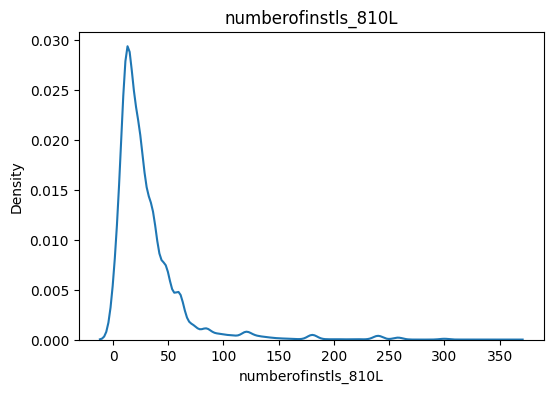

========== [overdueamountmax_950A] ==========
데이터 타입: float64
결측치의 비율: 0.2%
최솟값: 0.0
최댓값: 37150.052
평균값: 17.813
중간값: 0.0


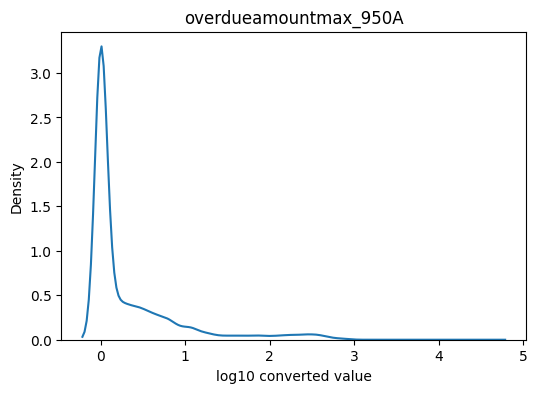

========== [overdueamountmaxdatemonth_494T] ==========
데이터 타입: float64
결측치의 비율: 0.2%
최솟값: 1.0
최댓값: 12.0
평균값: 6.623
중간값: 7.0


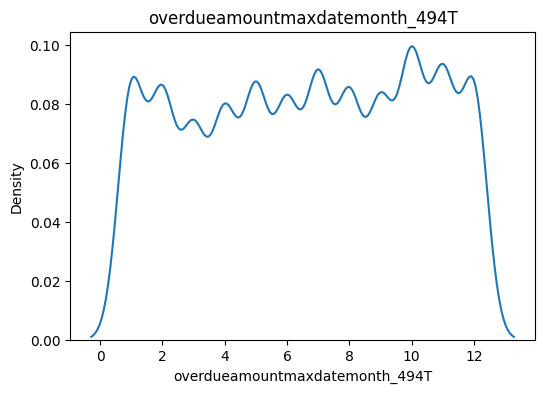

========== [overdueamountmaxdateyear_432T] ==========
데이터 타입: float64
결측치의 비율: 0.2%
최솟값: 2008.0
최댓값: 2020.0
평균값: 2018.272
중간값: 2019.0


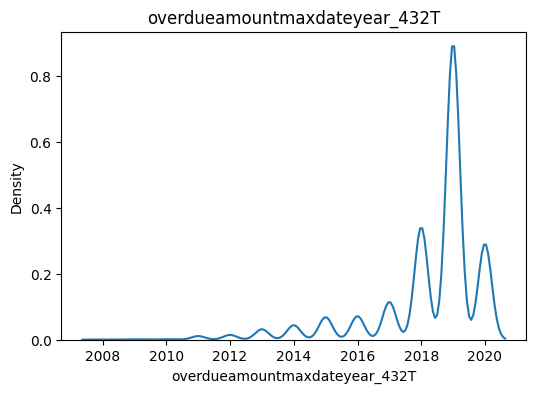

========== [periodicityofpmts_997M] ==========
데이터 타입: object
결측치의 비율: 4.2%
최솟값: 0a59e5b4
최댓값: f50a4e2c
- - - - - - - - - - 
value_counts:
a55475b1    18817
a0b598e4    15583
3ecc50a0      256
d479a207      226
842dca9f       54
9c7cbdb6       14
e24bdef1        4
0a59e5b4        3
f50a4e2c        3
e4c51201        2
Name: periodicityofpmts_997M, dtype: int64
- - - - - - - - - - 


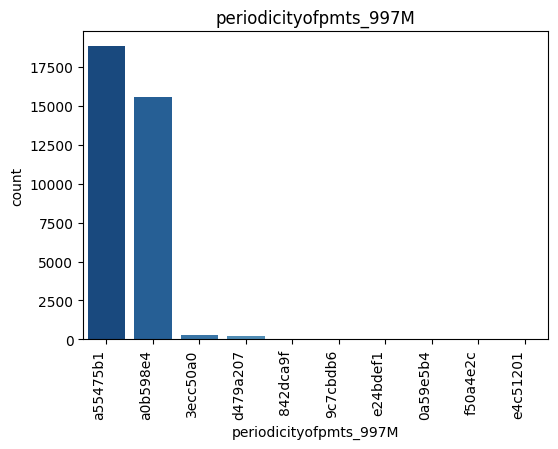

========== [pmtdaysoverdue_1135P] ==========
데이터 타입: float64
결측치의 비율: 0.2%
최솟값: 0.0
최댓값: 167175.0
평균값: 67.693
중간값: 0.0


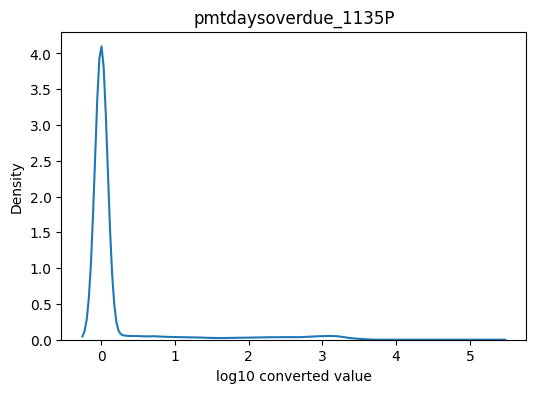

========== [pmtmethod_731M] ==========
데이터 타입: object
결측치의 비율: 0.0%
최솟값: 10984579
최댓값: f6e26148
- - - - - - - - - - 
value_counts:
a55475b1    18827
f6e26148     9686
dbcbe8f8     4581
e914c86c     3249
d01fcb1e       98
5f8f7038       51
a7c1fc40        5
b03dfa05        2
10984579        1
Name: pmtmethod_731M, dtype: int64
- - - - - - - - - - 


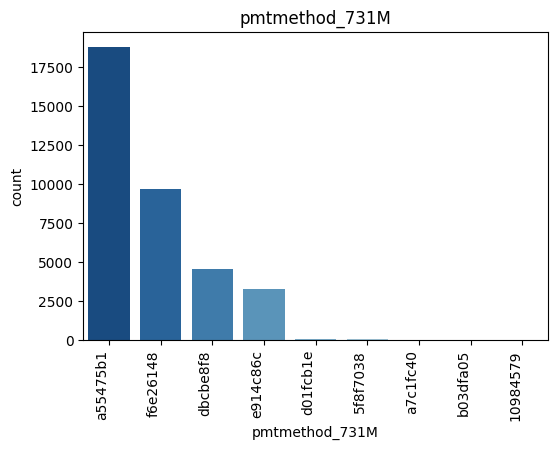

========== [pmtnumpending_403L] ==========
데이터 타입: float64
결측치의 비율: 30.3%
최솟값: 0.0
최댓값: 300.0
평균값: 20.664
중간값: 13.0


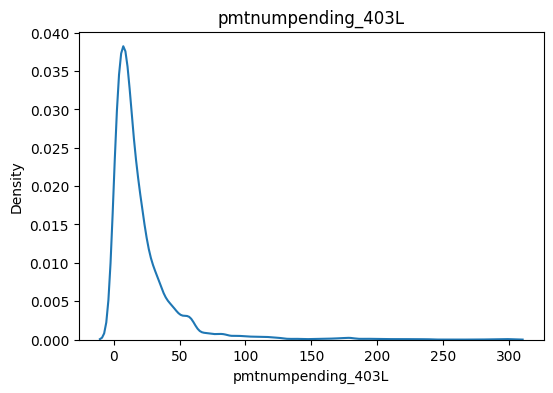

========== [purposeofcred_722M] ==========
데이터 타입: object
결측치의 비율: 0.0%
최솟값: 164ee705
최댓값: e8f3b178
- - - - - - - - - - 
value_counts:
60c73645        27903
96a8fdfe         6151
a55475b1         1986
164ee705          147
5065c2b8           92
e19fdece           83
28bfa260           61
9e302002           31
P188_162_121       17
7a7d6960           16
6ec903ee            9
e8f3b178            4
Name: purposeofcred_722M, dtype: int64
- - - - - - - - - - 


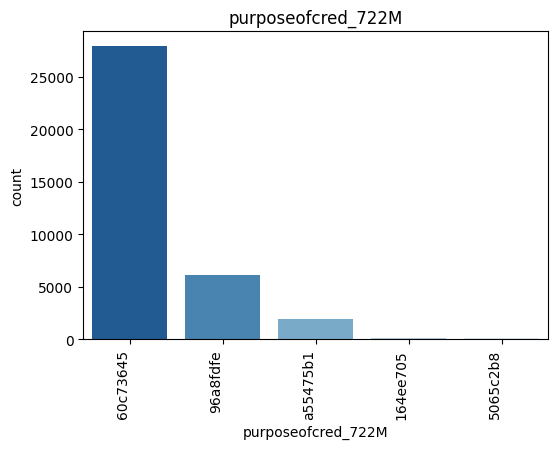

========== [residualamount_127A] ==========
데이터 타입: float64
결측치의 비율: 24.4%
최솟값: 0.0
최댓값: 2187568.2
평균값: 57942.299
중간값: 14461.327


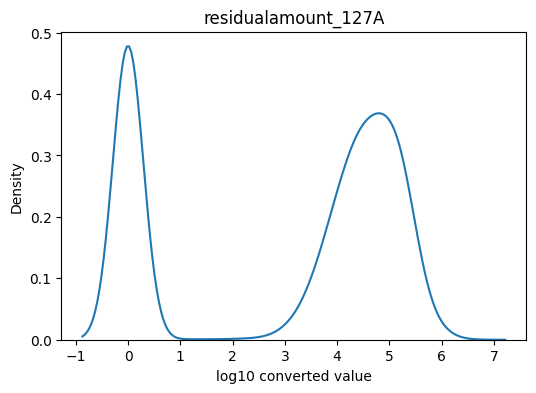

========== [residualamount_3940956A] ==========
데이터 타입: float64
결측치의 비율: 24.9%
최솟값: 0.0
최댓값: 1442545.6
평균값: 42404.571
중간값: 11146.89


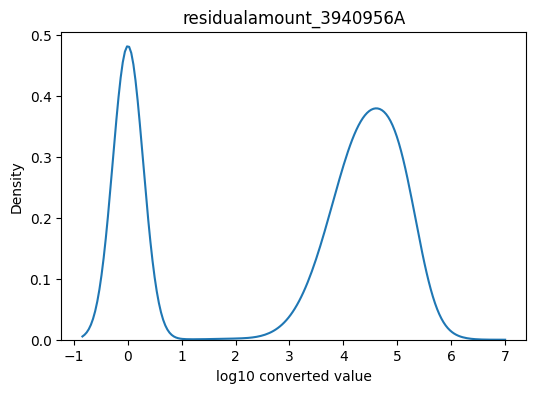

========== [subjectrole_326M] ==========
데이터 타입: object
결측치의 비율: 0.0%
최솟값: 15f04f45
최댓값: fa4f56f1
- - - - - - - - - - 
value_counts:
ab3c25cf     25606
a55475b1     10333
fa4f56f1       263
15f04f45       165
daf49a8a       108
P28_48_88       25
Name: subjectrole_326M, dtype: int64
- - - - - - - - - - 


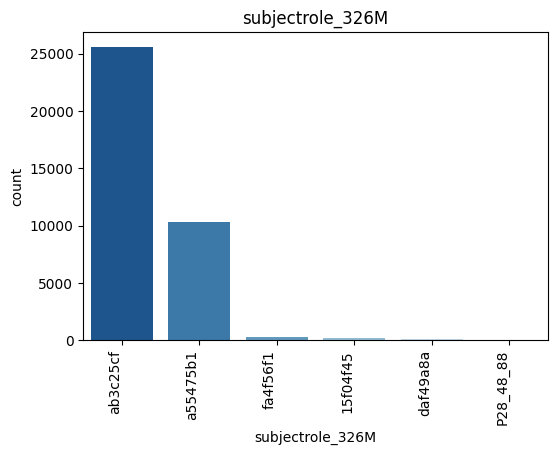

========== [subjectrole_43M] ==========
데이터 타입: object
결측치의 비율: 0.0%
최솟값: 15f04f45
최댓값: fa4f56f1
- - - - - - - - - - 
value_counts:
ab3c25cf    20531
a55475b1    15407
fa4f56f1      268
daf49a8a      180
15f04f45      113
71ddaa88        1
Name: subjectrole_43M, dtype: int64
- - - - - - - - - - 


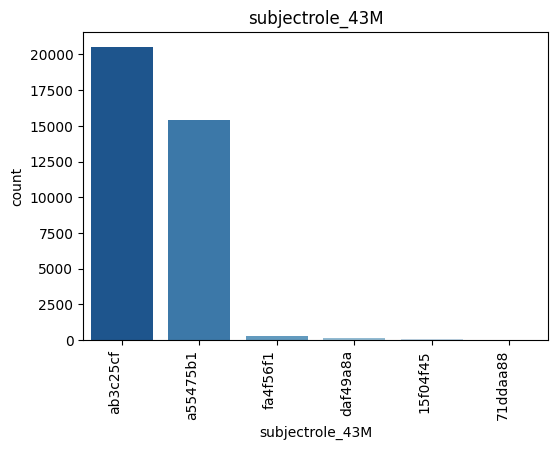

========== [totalamount_503A] ==========
데이터 타입: float64
결측치의 비율: 0.1%
최솟값: 0.0
최댓값: 796800000.0
평균값: 251204.151
중간값: 82998.4


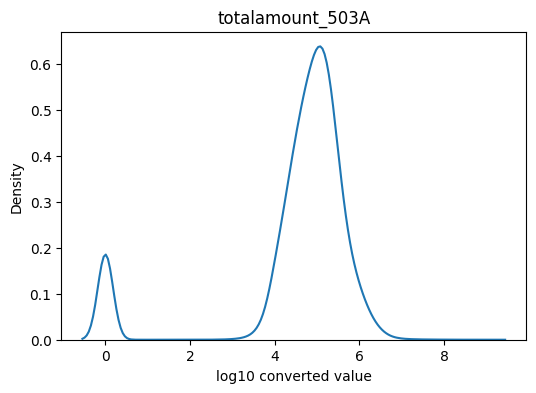

========== [totalamount_881A] ==========
데이터 타입: float64
결측치의 비율: 14.3%
최솟값: 0.0
최댓값: 86780410.0
평균값: 290721.387
중간값: 127548.5


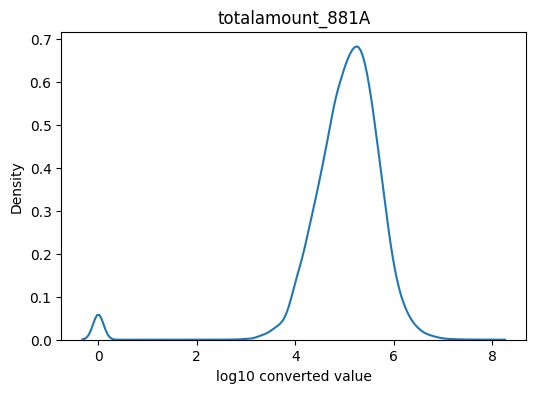

In [30]:
# https://www.notion.so/ML-Project-Home-Credit-b8ad4939d3fe47e2a5e9ba0b18a23868
# 위 링크에서 credit_bureau_b_1의 그래프와 비교할 수 있습니다!
for col in aggregated_df.columns[1:]:
    print_info(aggregated_df, col)

In [31]:
# 결측치 처리
# P - 평균값 반올림
# M - 최빈값
# A - 평균값
# D - 최빈값
# L - 정수: 평균값 반올림, 실수: 평균값
# T - 최빈값

for col in aggregated_df.columns[1:]:
    if aggregated_df[col].isna().sum():
        if col.endswith('P'):
            mean_value = aggregated_df[col].mean()
            aggregated_df[col].fillna(round(mean_value), inplace=True)
        elif col.endswith(('M', 'D', 'T')):
            mode_value = aggregated_df[col].mode().iloc[0]
            aggregated_df[col].fillna(mode_value, inplace=True)
        elif col.endswith('A'):
            mean_value = aggregated_df[col].mean()
            aggregated_df[col].fillna(mean_value, inplace=True)
        elif col.endswith('L'):
            convert = aggregated_df[col].dropna().astype(int)
            lossless_flag = (convert == aggregated_df[col].dropna()).all()

            if lossless_flag:
                mean_value = aggregated_df[col].mean()
                aggregated_df[col].fillna(round(mean_value), inplace=True)
            else:
                mean_value = aggregated_df[col].mean()
                aggregated_df[col].fillna(mean_value, inplace=True)


In [32]:
aggregated_df

,case_id,amount_1115A,classificationofcontr_1114M,contractdate_551D,contractmaturitydate_151D,contractst_516M,contracttype_653M,credlmt_1052A,credlmt_3940954A,credor_3940957M,...,pmtdaysoverdue_1135P,pmtmethod_731M,pmtnumpending_403L,purposeofcred_722M,residualamount_127A,residualamount_3940956A,subjectrole_326M,subjectrole_43M,totalamount_503A,totalamount_881A
0,467,78000.000000,ea6782cc,2019-01,2021-08,7241344e,724be82a,3.000000e+06,1.565182e+06,P164_34_168,...,0.0,a55475b1,10.0,96a8fdfe,0.000000,42404.571137,fa4f56f1,ab3c25cf,1539000.00,485000.000
1,1445,132266.873000,01f63ac8,2014-11,2021-01,7241344e,4257cbed,4.000000e+05,2.370000e+05,74bd67a8,...,0.0,a55475b1,16.0,60c73645,0.000000,73044.180000,a55475b1,a55475b1,398400.31,142293.900
2,1934,73971.200000,ea6782cc,2012-10,2022-10,b919198c,f4e17141,9.800000e+05,4.900000e+05,3e8db15c,...,1889.0,a55475b1,0.0,96a8fdfe,0.000000,0.000000,ab3c25cf,ab3c25cf,526985.60,166942.805
3,3159,216093.738727,ea6782cc,2018-11,2020-11,7241344e,1c9c5356,1.320000e+05,1.320000e+05,b619fa46,...,0.0,a55475b1,21.0,60c73645,111858.700000,111858.700000,ab3c25cf,ab3c25cf,132000.00,0.000
4,3208,300000.000000,a55475b1,2016-08,2019-08,a55475b1,4257cbed,1.789356e+05,9.434055e+04,6ee1295b,...,0.0,dbcbe8f8,8.0,a55475b1,57942.299114,42404.571137,a55475b1,ab3c25cf,300000.00,68500.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36495,2701996,216093.738727,ea6782cc,2018-05,2022-05,7241344e,1c9c5356,0.000000e+00,0.000000e+00,b619fa46,...,0.0,a55475b1,21.0,60c73645,0.000000,0.000000,ab3c25cf,ab3c25cf,0.00,388703.400
36496,2702661,21420.000000,ea6782cc,2020-05,2020-11,7241344e,4257cbed,1.789356e+05,9.434055e+04,P0_31_66,...,0.0,f6e26148,2.0,60c73645,57942.299114,42404.571137,ab3c25cf,ab3c25cf,21420.00,281932.800
36497,2703357,731886.060000,07b11743,2018-04,2020-11,7241344e,1c9c5356,7.200000e+04,7.200000e+04,904adb51,...,0.0,a55475b1,31.0,96a8fdfe,72000.000000,72000.000000,ab3c25cf,ab3c25cf,401943.03,279862.610
36498,2703377,216093.738727,ea6782cc,2014-01,2022-01,7241344e,1c9c5356,0.000000e+00,0.000000e+00,b619fa46,...,0.0,a55475b1,21.0,60c73645,0.000000,0.000000,ab3c25cf,ab3c25cf,0.00,205540.000


In [33]:
aggregated_df.to_csv('aggregated_credit_bureau_b_1.csv')

In [34]:
train_static = pd.concat(
    [
        pd.read_csv(base_path + "csv_files/train/train_static_0_0.csv"),
        pd.read_csv(base_path + "csv_files/train/train_static_0_1.csv"),
    ],
    axis=0,
)
train_static_cb = pd.read_csv(base_path + "csv_files/train/train_static_cb_0.csv")

test_static = pd.concat(
    [
        pd.read_csv(base_path + "csv_files/test/test_static_0_0.csv"),
        pd.read_csv(base_path + "csv_files/test/test_static_0_1.csv"),
        pd.read_csv(base_path + "csv_files/test/test_static_0_2.csv"),
    ],
    axis=0,
)
test_static_cb = pd.read_csv(base_path + "csv_files/test/test_static_cb_0.csv")

In [35]:
used_columns

['birth_259D',
 'contaddr_district_15M',
 'contaddr_matchlist_1032L',
 'contaddr_smempladdr_334L',
 'education_927M',
 'empladdr_district_926M',
 'empladdr_zipcode_114M',
 'incometype_1044T',
 'language1_981M',
 'mainoccupationinc_384A',
 'num_group1',
 'personindex_1023L',
 'persontype_1072L',
 'registaddr_district_1083M',
 'registaddr_zipcode_184M',
 'role_1084L',
 'safeguarantyflag_411L',
 'sex_738L',
 'type_25L']

In [36]:
new_test_person_1 = test_person_1[test_person_1['num_group1'] == 0].loc[:, ['case_id'] + used_columns]
new_test_person_1

,case_id,birth_259D,contaddr_district_15M,contaddr_matchlist_1032L,contaddr_smempladdr_334L,education_927M,empladdr_district_926M,empladdr_zipcode_114M,incometype_1044T,language1_981M,mainoccupationinc_384A,num_group1,personindex_1023L,persontype_1072L,registaddr_district_1083M,registaddr_zipcode_184M,role_1084L,safeguarantyflag_411L,sex_738L,type_25L
0,57543,1996-08-01,P107_30_170,False,False,P97_36_170,P16_81_96,P144_138_111,EMPLOYED,P209_127_106,36000.0,0,0.0,1.0,P107_30_170,P144_138_111,CL,False,M,PRIMARY_MOBILE
3,57549,1992-03-01,P7_110_89,False,False,P97_36_170,P7_110_89,P166_45_172,EMPLOYED,P10_39_147,15000.0,0,0.0,1.0,P7_110_89,P166_45_172,EM,False,M,PRIMARY_MOBILE
7,57551,1990-08-01,P158_121_167,False,False,P97_36_170,P109_39_170,P144_138_111,EMPLOYED,P10_39_147,24000.0,0,0.0,1.0,P158_121_167,P64_108_184,CL,False,M,PRIMARY_MOBILE


In [37]:
used_columns_guarantee = ['contaddr_zipcode_807M', 'persontype_792L', 'relationshiptoclient_415T', 'remitter_829L']

temp_test = test_person_1.loc[:, ['case_id'] + used_columns_guarantee]
result_test = temp_test.groupby('case_id').aggregate({
    'contaddr_zipcode_807M': mode_series,
    'persontype_792L': mean_rounded,
    'relationshiptoclient_415T': mode_series,
    'remitter_829L': is_false
})
result_test

,contaddr_zipcode_807M,persontype_792L,relationshiptoclient_415T,remitter_829L
case_id,,,,
57543,a55475b1,3,OTHER,False
57549,a55475b1,3,SIBLING,False
57551,a55475b1,3,FRIEND,False


In [38]:
person_test_final_features = pd.merge(new_test_person_1, result_test, how='left', on='case_id')
person_test_final_features.drop('num_group1', axis=1, inplace=True)
person_test_final_features

,case_id,birth_259D,contaddr_district_15M,contaddr_matchlist_1032L,contaddr_smempladdr_334L,education_927M,empladdr_district_926M,empladdr_zipcode_114M,incometype_1044T,language1_981M,...,registaddr_district_1083M,registaddr_zipcode_184M,role_1084L,safeguarantyflag_411L,sex_738L,type_25L,contaddr_zipcode_807M,persontype_792L,relationshiptoclient_415T,remitter_829L
0,57543,1996-08-01,P107_30_170,False,False,P97_36_170,P16_81_96,P144_138_111,EMPLOYED,P209_127_106,...,P107_30_170,P144_138_111,CL,False,M,PRIMARY_MOBILE,a55475b1,3,OTHER,False
1,57549,1992-03-01,P7_110_89,False,False,P97_36_170,P7_110_89,P166_45_172,EMPLOYED,P10_39_147,...,P7_110_89,P166_45_172,EM,False,M,PRIMARY_MOBILE,a55475b1,3,SIBLING,False
2,57551,1990-08-01,P158_121_167,False,False,P97_36_170,P109_39_170,P144_138_111,EMPLOYED,P10_39_147,...,P158_121_167,P64_108_184,CL,False,M,PRIMARY_MOBILE,a55475b1,3,FRIEND,False


In [39]:
test_credit_bureau_b_1['periodicityofpmts_997L']
test_credit_bureau_b_1.drop(columns='periodicityofpmts_997L', inplace=True)

In [40]:
aggregated_df_test = aggregate_by_case_id(test_credit_bureau_b_1)
aggregated_df_test

,case_id,amount_1115A,classificationofcontr_1114M,contractdate_551D,contractmaturitydate_151D,contractst_516M,contracttype_653M,credlmt_1052A,credlmt_228A,credlmt_3940954A,...,pmtmethod_731M,pmtnumpending_403L,purposeofcred_722M,residualamount_1093A,residualamount_127A,residualamount_3940956A,subjectrole_326M,subjectrole_43M,totalamount_503A,totalamount_881A
0,57660,NaN,ea6782cc,2013-03,2021-12,7241344e,1c9c5356,133279.0,NaN,66639.500,...,a55475b1,NaN,60c73645,NaN,109099.580,54549.790,a55475b1,ab3c25cf,133279.0,16800.0
1,57679,60000.0,ea6782cc,2019-10,2021-06,7241344e,4257cbed,0.0,NaN,0.000,...,dbcbe8f8,12.0,60c73645,NaN,0.000,0.000,ab3c25cf,ab3c25cf,30000.0,86800.0
2,57689,NaN,ea6782cc,2019-12,2021-12,7241344e,1c9c5356,144958.8,NaN,72479.402,...,a55475b1,NaN,60c73645,NaN,82776.805,41388.402,a55475b1,a55475b1,144958.8,NaN
3,57700,312800.0,01f63ac8,2019-05,2023-10,8f3a197f,4257cbed,0.0,NaN,0.000,...,e914c86c,36.0,60c73645,NaN,0.000,0.000,ab3c25cf,a55475b1,312800.0,NaN
4,57767,NaN,ea6782cc,2013-10,2021-10,7241344e,1c9c5356,0.0,64000.0,0.000,...,a55475b1,NaN,60c73645,0.0,0.000,0.000,ab3c25cf,ab3c25cf,0.0,64000.0


In [41]:
aggregated_df_test.drop(columns=['credlmt_228A', 'interesteffectiverate_369L', 'residualamount_1093A'], inplace=True)
aggregated_df_test


,case_id,amount_1115A,classificationofcontr_1114M,contractdate_551D,contractmaturitydate_151D,contractst_516M,contracttype_653M,credlmt_1052A,credlmt_3940954A,credor_3940957M,...,pmtdaysoverdue_1135P,pmtmethod_731M,pmtnumpending_403L,purposeofcred_722M,residualamount_127A,residualamount_3940956A,subjectrole_326M,subjectrole_43M,totalamount_503A,totalamount_881A
0,57660,NaN,ea6782cc,2013-03,2021-12,7241344e,1c9c5356,133279.0,66639.500,b619fa46,...,0,a55475b1,NaN,60c73645,109099.580,54549.790,a55475b1,ab3c25cf,133279.0,16800.0
1,57679,60000.0,ea6782cc,2019-10,2021-06,7241344e,4257cbed,0.0,0.000,50babcd4,...,0,dbcbe8f8,12.0,60c73645,0.000,0.000,ab3c25cf,ab3c25cf,30000.0,86800.0
2,57689,NaN,ea6782cc,2019-12,2021-12,7241344e,1c9c5356,144958.8,72479.402,b619fa46,...,0,a55475b1,NaN,60c73645,82776.805,41388.402,a55475b1,a55475b1,144958.8,NaN
3,57700,312800.0,01f63ac8,2019-05,2023-10,8f3a197f,4257cbed,0.0,0.000,74bd67a8,...,1,e914c86c,36.0,60c73645,0.000,0.000,ab3c25cf,a55475b1,312800.0,NaN
4,57767,NaN,ea6782cc,2013-10,2021-10,7241344e,1c9c5356,0.0,0.000,b619fa46,...,0,a55475b1,NaN,60c73645,0.000,0.000,ab3c25cf,ab3c25cf,0.0,64000.0


In [42]:
aggregated_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 40 columns):
 #   Column                          Non-Null Count  Dtype    
---  ------                          --------------  -----    
 0   case_id                         5 non-null      int64    
 1   amount_1115A                    2 non-null      float64  
 2   classificationofcontr_1114M     5 non-null      object   
 3   contractdate_551D               5 non-null      period[M]
 4   contractmaturitydate_151D       5 non-null      period[M]
 5   contractst_516M                 5 non-null      object   
 6   contracttype_653M               5 non-null      object   
 7   credlmt_1052A                   5 non-null      float64  
 8   credlmt_3940954A                5 non-null      float64  
 9   credor_3940957M                 5 non-null      object   
 10  credquantity_1099L              5 non-null      int64    
 11  credquantity_984L               3 non-null      float64  
 12  debtpastduev

In [43]:
for col in aggregated_df_test.columns[1:]:
    if aggregated_df_test[col].isna().sum() != len(aggregated_df_test[col]):
        if col.endswith('P'):
            mean_value = aggregated_df_test[col].mean()
            aggregated_df_test[col].fillna(round(mean_value), inplace=True)
        elif col.endswith(('M', 'D', 'T')):
            mode_value = aggregated_df_test[col].mode().iloc[0]
            aggregated_df_test[col].fillna(mode_value, inplace=True)
        elif col.endswith('A'):
            mean_value = aggregated_df_test[col].mean()
            aggregated_df_test[col].fillna(mean_value, inplace=True)
        elif col.endswith('L'):
            convert = aggregated_df_test[col].dropna().astype(int)
            lossless_flag = (convert == aggregated_df_test[col].dropna()).all()

            if lossless_flag:
                mean_value = aggregated_df_test[col].mean()
                aggregated_df_test[col].fillna(round(mean_value), inplace=True)
            else:
                mean_value = aggregated_df_test[col].mean()
                aggregated_df_test[col].fillna(mean_value, inplace=True)

In [44]:
aggregated_df_test

,case_id,amount_1115A,classificationofcontr_1114M,contractdate_551D,contractmaturitydate_151D,contractst_516M,contracttype_653M,credlmt_1052A,credlmt_3940954A,credor_3940957M,...,pmtdaysoverdue_1135P,pmtmethod_731M,pmtnumpending_403L,purposeofcred_722M,residualamount_127A,residualamount_3940956A,subjectrole_326M,subjectrole_43M,totalamount_503A,totalamount_881A
0,57660,186400.0,ea6782cc,2013-03,2021-12,7241344e,1c9c5356,133279.0,66639.500,b619fa46,...,0,a55475b1,24.0,60c73645,109099.580,54549.790,a55475b1,ab3c25cf,133279.0,16800.000000
1,57679,60000.0,ea6782cc,2019-10,2021-06,7241344e,4257cbed,0.0,0.000,50babcd4,...,0,dbcbe8f8,12.0,60c73645,0.000,0.000,ab3c25cf,ab3c25cf,30000.0,86800.000000
2,57689,186400.0,ea6782cc,2019-12,2021-12,7241344e,1c9c5356,144958.8,72479.402,b619fa46,...,0,a55475b1,24.0,60c73645,82776.805,41388.402,a55475b1,a55475b1,144958.8,55866.666667
3,57700,312800.0,01f63ac8,2019-05,2023-10,8f3a197f,4257cbed,0.0,0.000,74bd67a8,...,1,e914c86c,36.0,60c73645,0.000,0.000,ab3c25cf,a55475b1,312800.0,55866.666667
4,57767,186400.0,ea6782cc,2013-10,2021-10,7241344e,1c9c5356,0.0,0.000,b619fa46,...,0,a55475b1,24.0,60c73645,0.000,0.000,ab3c25cf,ab3c25cf,0.0,64000.000000


In [47]:
train_person_1[train_person_1['num_group1'] == 0]['personindex_1023L'].value_counts()

0.0    1526659
Name: personindex_1023L, dtype: int64